In [ ]:
!apt-get install openjdk-8-jdk -qq > /dev/null

!wget -q http://www-eu.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz

!tar xf spark-3.0.2-bin-hadoop2.7.tgz

!pip install -q findspark

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark

findspark.init() # SPARK_HOME

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!pip install --upgrade pandas_profiling

In [ ]:
from pyspark.sql import SQLContext
import pandas as pd
import pandas_profiling

## Data Profiling
------------------

This library should cover some basic functionality related to data profiling. As for its basic specifications, this class should be able to:

* Create charts with top N values per column (where N is a parameter specified by the user) and arrange them desc or asc depending on the user specifications
* Display number of unique values up to a threshold of unique values specified by the user
* Allow the user to specify combinations of variables that render a register 'unique'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/2021Q1_DSF_contents/DATA/"
df = pd.read_csv(DATA_PATH + "pokemon.csv")

In [ ]:
df.head()

Name Type 1  Type 2  HP  ...  Sp. Def  Speed  Generation  Legendary
0      Bulbasaur  Grass  Poison  45  ...       65     45           1      False
1        Ivysaur  Grass  Poison  60  ...       80     60           1      False
2       Venusaur  Grass  Poison  80  ...      100     80           1      False
3  Mega Venusaur  Grass  Poison  80  ...      120     80           1      False
4     Charmander   Fire     NaN  39  ...       50     65           1      False

[5 rows x 11 columns]

In [ ]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Recrear Pandas Profiling en Spark

- Crear la funcion de calculo de dimensiones de la tabla y agregar un if con el verbose donde imprima mayor informacion
- Crear funcion de renombre de columnas, tu le das el nuevo nombre y los indices de las columnas a renombrar
- Crear funcion de limpieza de columnas, todo en minusculas, sin acentos o caracteres especiales y cambiar espacios en blanco por guiones bajos
--------------------------
- Crear funcion de generador de ID
- Crear funcion que calcule correlacion entre dos variables
- Crear funcion que detecte y filtre los outlier por el metodo de tukey




In [63]:
import re
from tabulate import tabulate
from pyspark.sql.functions import col, mean, min, max, stddev_pop, expr, desc, asc, concat_ws, concat, udf
from pyspark.sql.types import * 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df_p = data_profiler(df)

Cleaning Cache!


DataFrame[Type 1_Type 2: string, Bug: bigint, Dark: bigint, Dragon: bigint, Electric: bigint, Fairy: bigint, Fighting: bigint, Fire: bigint, Flying: bigint, Ghost: bigint, Grass: bigint, Ground: bigint, Ice: bigint, Normal: bigint, Poison: bigint, Psychic: bigint, Rock: bigint, Steel: bigint, Water: bigint, null: bigint]

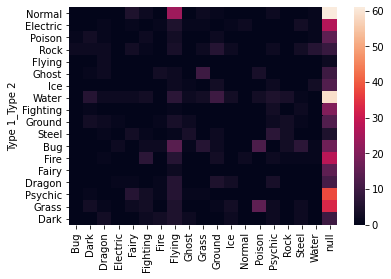

In [82]:
df_p.cross(var_1='Type 1',var_2='Type 2')

In [56]:
df_p.dim()

The dataset has: 800 rows, 11 columns.


(800, 11)

In [57]:
df_p.rename(['NAME', 'Type1'], [0,1])

col rename: Name => NAME
col rename: Type 1 => Type1


In [58]:
df_p.df

DataFrame[NAME: string, Type1: string, Type 2: string, HP: int, Attack: int, Defense: int, Sp. Atk: int, Sp. Def: int, Speed: int, Generation: int, Legendary: boolean]

In [59]:
df_p.clean_names()

col rename: NAME => name
col rename: Type1 => type1
col rename: Type 2 => type_2
col rename: HP => hp
col rename: Attack => attack
col rename: Defense => defense
col rename: Sp. Atk => sp_atk
col rename: Sp. Def => sp_def
col rename: Speed => speed
col rename: Generation => generation
col rename: Legendary => legendary


In [62]:
df_p.id_gen('NAME')

The field: "NAME" has 1 duplicates
+----+--------+---------+
|    | NAME   |   count |
|----+--------+---------|
|  0 |        |     800 |
+----+--------+---------+


In [88]:
class data_profiler():
    '''
    General purpose class for data profiling
    '''
    
    #####################################
    # Class constructor
    # ----------------------------------
    # IN:
    # - df: the dataset to be analyzed.
    #####################################
    def __init__(self, df):
        print('Cleaning Cache!')
        spark.catalog.clearCache()
        self.df = df.cache()
    
    #####################################
    # DF dimension
    # ----------------------------------
    # Gets the dimension of the dataset. 
    #
    # IN:
    # - verbose: prints additional info.
    # OUT:
    # - A tuple with the number of rows
    #   and columns.
    #####################################
    def dim(self, verbose=True):
        cols = len(self.df.columns)
        rows = self.df.count()
        
        if verbose: 
            print('The dataset has: %d rows, %d columns.' % 
                  (rows, cols))
            
        return (rows, cols)
        
    #####################################
    # Rename columns
    # ----------------------------------
    # Renames the columns of the dataset.
    #  
    # IN:
    # - new_names: list of new names
    # - rename_indices: indices of columns
    #   to be renamed. 
    # - verbose: prints additional info.
    #####################################
    def rename(self, new_names, rename_indices=None, verbose=True):
        old_names = self.df.columns
        # Check if rename indices were given
        if rename_indices:
            if len(rename_indices) == len(new_names):
                old_names = [n for i, n in enumerate(old_names) if i in rename_indices]
            else:
                print('''rename indices and new names should 
                have the same length, received: %d, %d''' % (len(rename_indices),
                                                            len(new_names)) )
                return -1
        # Rename columns
        for i, name in enumerate(new_names):
            self.df = self.df.withColumnRenamed(old_names[i], name)
            if verbose:
                print('col rename: %s => %s' % (old_names[i], name))
        # Cache results        
        self.df.cache()
        
    #####################################
    # Clean names
    # ----------------------------------
    # Remove strange characters,
    # upper cases and spaces from the
    # names.
    #
    # IN:
    # - verbose: prints additional info.
    # OUT: 
    # - clean name (lowercase, only ascii, 
    # no white space)
    #####################################
    def clean_names(self, verbose=True):  
        new_names = [re.sub('[^a-z_0-9]', '', 
                            n.lower().replace(' ', '_')) 
                     for n in self.df.columns]
        self.rename(new_names, verbose=verbose)
        # Cache results        
        self.df.cache()
        
    #####################################
    # Id generator
    # ----------------------------------
    # Concatenates columns and tells user
    # if the resulting field is unique. 
    #
    # IN:
    # - cvars: variables to concatenate
    # - id_name: output variable name
    # - sep: character used for column
    #   name concatenation.
    # - verbose: prints additional info.
    #####################################
    def id_gen(self, id_name, *args, sep='_', verbose=True):  
        self.df = self.df.withColumn(id_name, 
                                concat_ws(sep,  *args))
        duplicates = self.df.groupBy(id_name)\
        .count().filter(col('count') > 1)\
        .count()
        if verbose:
            dduplicate = self.df.groupBy(id_name)\
            .count().filter(col('count') > 1).toPandas()
            print('The field: "%s" has %d duplicates' % (id_name, 
                                                         duplicates))
            print(tabulate(dduplicate.head(), 
                               headers='keys', 
                               tablefmt='psql'))
          
    #####################################
    # Corr
    # ----------------------------------
    # Computes the sample correlation
    # between two numerical variables. 
    #
    # IN:
    # - var_i: variables to obtain correlation
    # - verbose: prints additional info.
    # OUT:
    # - sample correlation
    # - extract a sample of the two variables
    #   and display a scatter plot. 
    #####################################
    def corr(self, var_1, var_2, verbose=True):
        var1_type = self.df.select(var_1).schema.fields[0].dataType
        var2_type = self.df.select(var_2).schema.fields[0].dataType
        num_types = [IntegerType(), DoubleType(), FloatType(), LongType()]
        if  var1_type not in num_types or var2_type not in num_types:
            print('Error, both var_1 and var_2 should be numeric')
            return -1
        _corr = self.df.stat.corr(var_1, var_2)
        if verbose:
            print('The correlation between %s and %s is: %f' % (
                var_1,
                var_2,
                _corr
            ))
        return _corr
    

    #####################################
    # Frequent items (OPTIONAL)
    # ----------------------------------
    # Computes the sample cross tab 
    # between two categorical variables. 
    #
    # IN:
    # - var_: array of variables to obtain the 
    #          frequent item sets.
    # - verbose: prints additional info.
    # OUT:
    # - data_frame with frequent items
    #####################################
    def freq(self, vars_, supp=.04):
        cat_types = [StringType(), BooleanType()]
        for var_i in [self.df.select(var).schema.fields[0].dataType for var in vars_]:
            if  var_i not in cat_types:
                print('Error, both var_1 and var_2 should be categorical')
                return -1
        _freq = self.df.stat.freqItems(vars_, supp)
        return _freq
    
    #####################################
    # Cross tab (OPTIONAL)
    # ----------------------------------
    # Computes the sample cross tab 
    # between two categorical variables. 
    #
    # IN:
    # - var_i: variables to obtain crosstab
    # - verbose: prints additional info.
    # - supp: minimum number of instances. 
    # OUT:
    # - data_frame with cross tabs
    #####################################
    def cross(self, var_1, var_2, plot=True):
        var1_type = self.df.select(var_1).schema.fields[0].dataType
        var2_type = self.df.select(var_2).schema.fields[0].dataType
        cat_types = [StringType(), BooleanType()]
        if  var1_type not in cat_types or var2_type not in cat_types:
            print('Error, both var_1 and var_2 should be categorical')
            return -1
        _cross = self.df.stat.crosstab(var_1, var_2)

        if plot:
            plot_cross = _cross.toPandas()
            plot_cross.set_index(var_1 + '_' + var_2, inplace=True)
            sns.heatmap(plot_cross)

        return _cross
    
    
    #####################################
    # Outliers
    # ----------------------------------
    # Remove outliers with the Tuckey criteria.
    # either 1.5*IQR or 3*IQR
    #
    # IN:
    # - Data with outliers
    # OUT:
    # - Data without outliers
    # - if verbose print percent of outliers
    #   being removed from the data. 
    ##################################### 
    def outliers(self, col,thresh=1.5):
        q1, q3 = self.df.approxQuantile(col, [0.25, 0.75], 0.01)
        IQR = q3 - q1
        
        min_thresh = q1 - thresh * IQR
        max_thresh = q3 + thresh * IQR
        
        print(self.df.count())
        df_no_outliers = self.df.filter(F.col(col).between(min_thresh, max_thresh))
    
        return df_no_outliers
    
    #####################################
    # General stats
    # ----------------------------------
    # Remove strange characters,
    # upper cases and spaces from the
    # names.
    #
    # IN:
    # - max, min, mean, sttdev, Q1, Q2, Q3 for numerical variables
    # - top_n: top values in counts
    # - verbose: prints additional info.
    # - Generates histograms for numerical variables
    # - bar plots for categorical variables
    # - plot correlation between numerical variables
    # OUT:
    # - A dictionary with general stats
    # per variable.
    #####################################   
    def generalStats(self, top_n=5, n_cuts=20, verbose=True, plots=True):
        types = [(f.name, f.dataType) for f in self.df.schema.fields]
        out_stats = {}
        for name, dtype in types:
            print(types)
            # For numerical values
            if dtype in [IntegerType(), DoubleType(), FloatType(), LongType()]:
                out_stats[name] = self.df\
                .select(min(name).alias('min'), 
                        expr("percentile_approx(%s, 0.25) as q25" % name),
                        expr("percentile_approx(%s, 0.50) as q50" % name),
                        expr("percentile_approx(%s, 0.75) as q75" % name),
                        max(name).alias('max'), 
                        mean(name).alias('mean'), 
                        stddev_pop(name).alias('std')).toPandas()
                if plots:
                    plot_data = self.df.select(name).rdd\
                    .flatMap(lambda x: x).histogram(n_cuts)
                    pd.DataFrame(
                        list(zip(*plot_data)), 
                        columns=['bin', name]
                    ).set_index('bin').plot(kind='bar')
            if dtype in [StringType(), BooleanType()]:
                out_stats[name] = self.df\
                .groupBy(name).count().orderBy(desc('count'))\
                .limit(top_n).toPandas()
                if plots:
                    # BarPlot
                    plot_data = out_stats[name].fillna('NONE')
                    plt.bar(plot_data[name], 
                            plot_data['count'],
                            align='center', alpha=0.5)
                    plt.ylabel('Count')
                    plt.title('Barchart (%s)' % name)
                    plt.show()
            if verbose:
                print('---------------------')
                print('Col: ' + name)
                print('---------------------')
                print(tabulate(out_stats[name], 
                               headers='keys', 
                               tablefmt='psql'))
        return out_stats

In [89]:
df_p = data_profiler(df)

Cleaning Cache!


In [90]:
df_p.dim()

The dataset has: 800 rows, 11 columns.


(800, 11)

In [91]:
df_p.clean_names()

col rename: Name => name
col rename: Type 1 => type_1
col rename: Type 2 => type_2
col rename: HP => hp
col rename: Attack => attack
col rename: Defense => defense
col rename: Sp. Atk => sp_atk
col rename: Sp. Def => sp_def
col rename: Speed => speed
col rename: Generation => generation
col rename: Legendary => legendary


In [92]:
df_p.corr('speed', 'defense')

The correlation between speed and defense is: 0.015227


0.015226598088597413

[('name', StringType), ('type_1', StringType), ('type_2', StringType), ('hp', IntegerType), ('attack', IntegerType), ('defense', IntegerType), ('sp_atk', IntegerType), ('sp_def', IntegerType), ('speed', IntegerType), ('generation', IntegerType), ('legendary', BooleanType)]


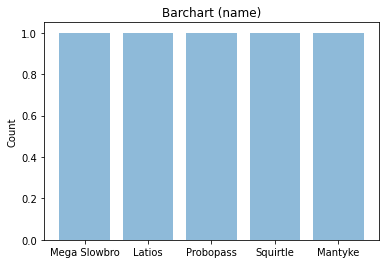

---------------------
Col: name
---------------------
+----+--------------+---------+
|    | name         |   count |
|----+--------------+---------|
|  0 | Mega Slowbro |       1 |
|  1 | Latios       |       1 |
|  2 | Probopass    |       1 |
|  3 | Squirtle     |       1 |
|  4 | Mantyke      |       1 |
+----+--------------+---------+
[('name', StringType), ('type_1', StringType), ('type_2', StringType), ('hp', IntegerType), ('attack', IntegerType), ('defense', IntegerType), ('sp_atk', IntegerType), ('sp_def', IntegerType), ('speed', IntegerType), ('generation', IntegerType), ('legendary', BooleanType)]


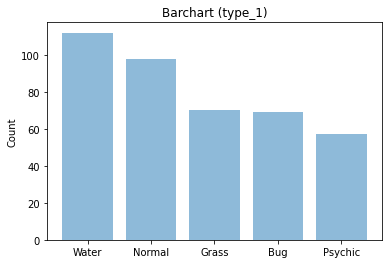

---------------------
Col: type_1
---------------------
+----+----------+---------+
|    | type_1   |   count |
|----+----------+---------|
|  0 | Water    |     112 |
|  1 | Normal   |      98 |
|  2 | Grass    |      70 |
|  3 | Bug      |      69 |
|  4 | Psychic  |      57 |
+----+----------+---------+
[('name', StringType), ('type_1', StringType), ('type_2', StringType), ('hp', IntegerType), ('attack', IntegerType), ('defense', IntegerType), ('sp_atk', IntegerType), ('sp_def', IntegerType), ('speed', IntegerType), ('generation', IntegerType), ('legendary', BooleanType)]


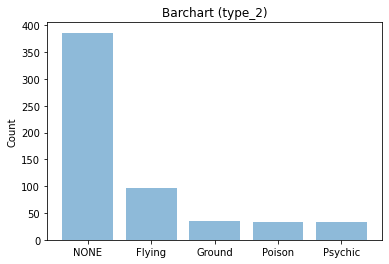

---------------------
Col: type_2
---------------------
+----+----------+---------+
|    | type_2   |   count |
|----+----------+---------|
|  0 |          |     386 |
|  1 | Flying   |      97 |
|  2 | Ground   |      35 |
|  3 | Poison   |      34 |
|  4 | Psychic  |      33 |
+----+----------+---------+
[('name', StringType), ('type_1', StringType), ('type_2', StringType), ('hp', IntegerType), ('attack', IntegerType), ('defense', IntegerType), ('sp_atk', IntegerType), ('sp_def', IntegerType), ('speed', IntegerType), ('generation', IntegerType), ('legendary', BooleanType)]
---------------------
Col: hp
---------------------
+----+-------+-------+-------+-------+-------+---------+---------+
|    |   min |   q25 |   q50 |   q75 |   max |    mean |     std |
|----+-------+-------+-------+-------+-------+---------+---------|
|  0 |     1 |    50 |    65 |    80 |   255 | 69.2588 | 25.5187 |
+----+-------+-------+-------+-------+-------+---------+---------+
[('name', StringType), ('type_1

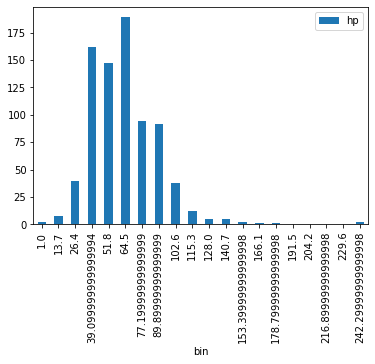

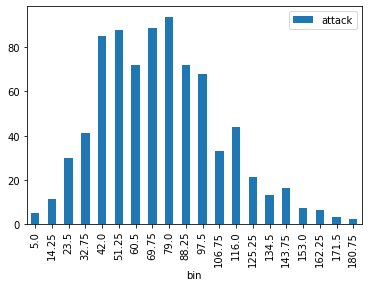

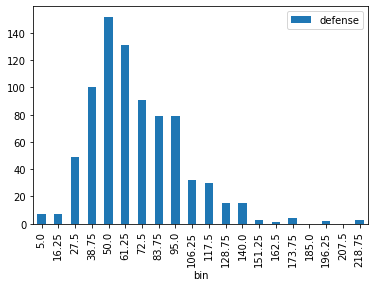

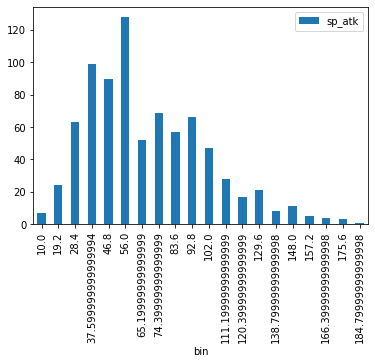

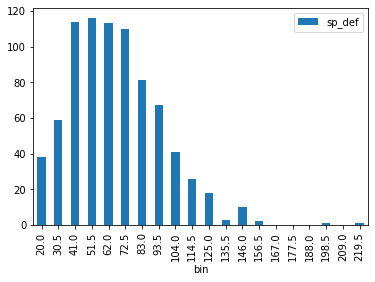

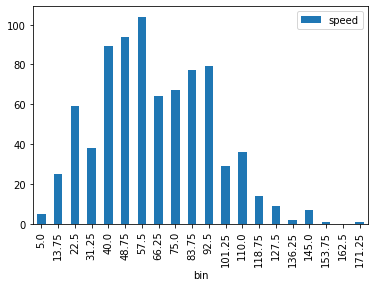

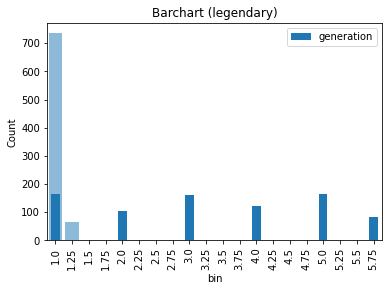

---------------------
Col: legendary
---------------------
+----+-------------+---------+
|    | legendary   |   count |
|----+-------------+---------|
|  0 | False       |     735 |
|  1 | True        |      65 |
+----+-------------+---------+


{'attack':    min  q25  q50  q75  max      mean        std
 0    5   55   75  100  190  79.00125  32.437074,
 'defense':    min  q25  q50  q75  max     mean        std
 0    5   50   70   90  230  73.8425  31.164005,
 'generation':    min  q25  q50  q75  max     mean       std
 0    1    2    3    5    6  3.32375  1.660252,
 'hp':    min  q25  q50  q75  max      mean        std
 0    1   50   65   80  255  69.25875  25.518705,
 'legendary':    legendary  count
 0      False    735
 1       True     65,
 'name':            name  count
 0  Mega Slowbro      1
 1        Latios      1
 2     Probopass      1
 3      Squirtle      1
 4       Mantyke      1,
 'sp_atk':    min  q25  q50  q75  max   mean        std
 0   10   49   65   95  194  72.82  32.701836,
 'sp_def':    min  q25  q50  q75  max     mean        std
 0   20   50   70   90  230  71.9025  27.811517,
 'speed':    min  q25  q50  q75  max     mean        std
 0    5   45   65   90  180  68.2775  29.042305,
 'type_1':     type_1  

In [93]:
df_p.generalStats()

DataFrame[Type 1_Type 2: string, Bug: bigint, Dark: bigint, Dragon: bigint, Electric: bigint, Fairy: bigint, Fighting: bigint, Fire: bigint, Flying: bigint, Ghost: bigint, Grass: bigint, Ground: bigint, Ice: bigint, Normal: bigint, Poison: bigint, Psychic: bigint, Rock: bigint, Steel: bigint, Water: bigint, null: bigint]

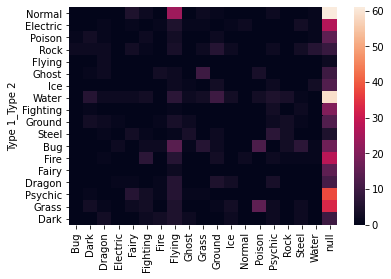

In [ ]:
df_p.cross(var_1='Type 1',var_2='Type 2')

In [ ]:
df_p.dim()

The dataset has: 800 rows, 11 columns.


(800, 11)

In [ ]:
df_p.rename(['NAME', 'Type1'], [0,1])

col rename: Name => NAME
col rename: Type 1 => Type1


In [ ]:
df_p.df

DataFrame[NAME: string, Type1: string, Type 2: string, HP: int, Attack: int, Defense: int, Sp. Atk: int, Sp. Def: int, Speed: int, Generation: int, Legendary: boolean]

In [ ]:
df_p.clean_names()

col rename: NAME => name
col rename: Type1 => type1
col rename: Type 2 => type_2
col rename: HP => hp
col rename: Attack => attack
col rename: Defense => defense
col rename: Sp. Atk => sp_atk
col rename: Sp. Def => sp_def
col rename: Speed => speed
col rename: Generation => generation
col rename: Legendary => legendary


In [ ]:
df_p.id_gen('NAME')

The field: "NAME" has 1 duplicates
+----+--------+---------+
|    | NAME   |   count |
|----+--------+---------|
|  0 |        |     800 |
+----+--------+---------+
